# First Animation

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
import galsim
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from numpy.ma import masked_array
from scipy.optimize import bisect
import galsim
import ipywidgets as widgets
from matplotlib.patches import Ellipse
from matplotlib import transforms
from matplotlib.animation import FuncAnimation

In [2]:
def _vkSeeing(r0_500, wavelength, L0):
    # von Karman profile FWHM from Tokovinin fitting formula
    kolm_seeing = galsim.Kolmogorov(r0_500=r0_500, lam=wavelength).fwhm
    r0 = r0_500 * (wavelength/500)**1.2
    arg = 1. - 2.183*(r0/L0)**0.356
    factor = np.sqrt(arg) if arg > 0.0 else 0.0
    return kolm_seeing*factor


def _r0_500(wavelength, L0, targetSeeing):
    """Returns r0_500 to use to get target seeing."""
    r0_500_max = min(1.0, L0*(1./2.183)**(-0.356)*(wavelength/500.)**1.2) # strictly less than Kolmogorov seeing
    r0_500_min = 0.01
    def _seeingResid(r0_500, wavelength, L0, targetSeeing):
        return _vkSeeing(r0_500, wavelength, L0) - targetSeeing
    return bisect(
        _seeingResid,
        r0_500_min,
        r0_500_max,
        args=(wavelength, L0, targetSeeing)
    )


def makeAtmosphere(
    airmass,
    rawSeeing,
    wavelength,
    rng,
    kcrit=0.2,
    screen_size=819.2,
    screen_scale=0.1,
    nproc=6
):
    targetFWHM = (
        rawSeeing/galsim.arcsec *
        airmass**0.6 *
        (wavelength/500.0)**(-0.3)
    )

    ud = galsim.UniformDeviate(rng)
    gd = galsim.GaussianDeviate(rng)

    # Use values measured from Ellerbroek 2008.
    altitudes = [0.0, 2.58, 5.16, 7.73, 12.89, 15.46]
    # Elevate the ground layer though.  Otherwise, PSFs come out too correlated
    # across the field of view.
    altitudes[0] = 0.2

    # Use weights from Ellerbroek too, but add some random perturbations.
    weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
    weights = [np.abs(w*(1.0 + 0.1*gd())) for w in weights]
    weights = np.clip(weights, 0.01, 0.8)  # keep weights from straying too far.
    weights /= np.sum(weights)  # renormalize

    # Draw outer scale from truncated log normal
    L0 = 0
    while L0 < 10.0 or L0 > 100:
        L0 = np.exp(gd() * 0.6 + np.log(25.0))
    # Given the desired targetFWHM and randomly selected L0, determine
    # appropriate r0_500
    r0_500 = _r0_500(wavelength, L0, targetFWHM)

    # Broadcast common outer scale across all layers
    L0 = [L0]*6

    # Uniformly draw layer speeds between 0 and max_speed.
    maxSpeed = 20.0
    speeds = [ud()*maxSpeed for _ in range(6)]
    # Isotropically draw directions.
    directions = [ud()*360.0*galsim.degrees for _ in range(6)]

    atmKwargs = dict(
        r0_500=r0_500,
        L0=L0,
        speed=speeds,
        direction=directions,
        altitude=altitudes,
        r0_weights=weights,
        rng=rng,
        screen_size=screen_size,
        screen_scale=screen_scale
    )

    ctx = multiprocessing.get_context('fork')
    atm = galsim.Atmosphere(mp_context=ctx, **atmKwargs)

    r0_500 = atm.r0_500_effective
    r0 = r0_500 * (wavelength/500.0)**(6./5)
    kmax = kcrit/r0

    with ctx.Pool(
        nproc,
        initializer=galsim.phase_screens.initWorker,
        initargs=galsim.phase_screens.initWorkerArgs()
    ) as pool:
        atm.instantiate(pool=pool, kmax=kmax, check='phot')

    return atm

In [3]:
rng = galsim.BaseDeviate()
atm = makeAtmosphere(1, 0.6 * galsim.arcsec, 500, rng, kcrit=0.2, screen_size=819.2, screen_scale=0.1, nproc=6)

In [4]:
## make pupil grid
X,Y = np.meshgrid(np.linspace(-8.36/2, 8.36/2, 100), np.linspace(-8.36/2, 8.36/2, 100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = ~np.logical_and(R <= 8.36/2, R >  8.36/2*0.58)

In [5]:
theta_x = widgets.FloatSlider(min=-14*60,max=14*60.0,step=60,description='theta_x:')
theta_y = widgets.FloatSlider(min=-14*60,max=14*60.0,step=60,description='theta_y:')
time = widgets.FloatSlider(min=0,max=15.0,step=0.02,description='time:')
ui = widgets.HBox([theta_x, theta_y, time])

def f(theta_x, theta_y, time):
    V = masked_array(atm.wavefront(X, Y, time, (theta_x*galsim.arcsec, theta_y*galsim.arcsec)), mask=mask)
    plt.title('Low Order Wavefront At Pupil')
    plt.imshow(V, origin='lower', cmap='coolwarm',vmin=-2000,vmax=2000)
    plt.axis('off')
    
out = widgets.interactive_output(f, {'theta_x': theta_x, 'theta_y': theta_y, 'time': time})
display(ui, out)

Output()

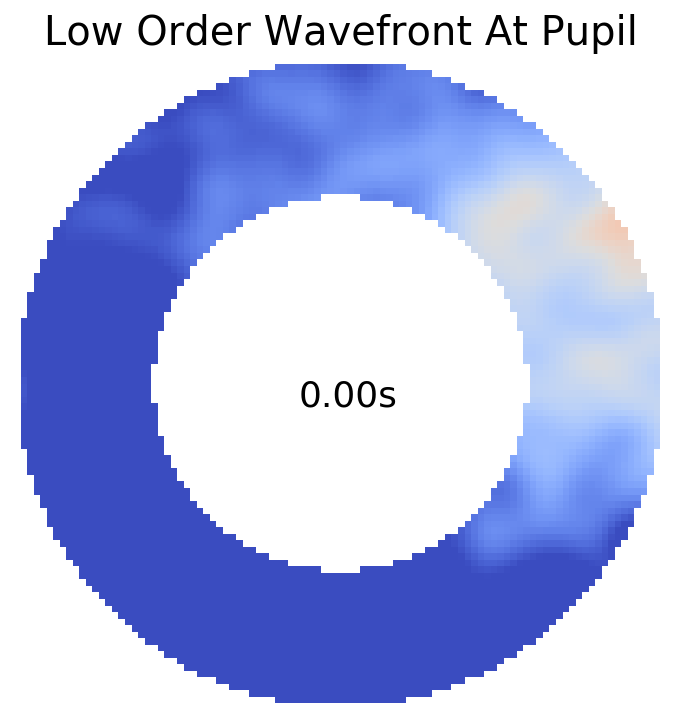

In [10]:
fps = 10
nSeconds = 15
ra = 0
dec = 0

fig = plt.figure(figsize=(6, 6))
V = masked_array(atm.wavefront(X, Y, 0, (ra*galsim.arcsec, dec*galsim.arcsec)), mask=mask)
plt.title('Low Order Wavefront At Pupil', fontsize=20)
im = plt.imshow(V*mask, origin='lower', cmap='coolwarm',vmin=-3000,vmax=3000)
# plt.colorbar()
txt = plt.text(43, 46, 'foo', color='k', fontsize=18)
plt.axis('off')

def animate(frame):
    seconds = frame / fps
    V = masked_array(atm.wavefront(X, Y, seconds, (0*galsim.arcsec, 0*galsim.arcsec)), mask=mask)
    txt.set_text(f'{seconds:.2f}s')
    im.set_array(V)
    return [txt,im]


ani = FuncAnimation(fig, animate, frames=fps*nSeconds,
                              interval=1000/fps, blit=True)

In [11]:
HTML(ani.to_html5_video())

In [12]:
ani.save('low_order_wavefront_at_pupil_seconds.mp4')

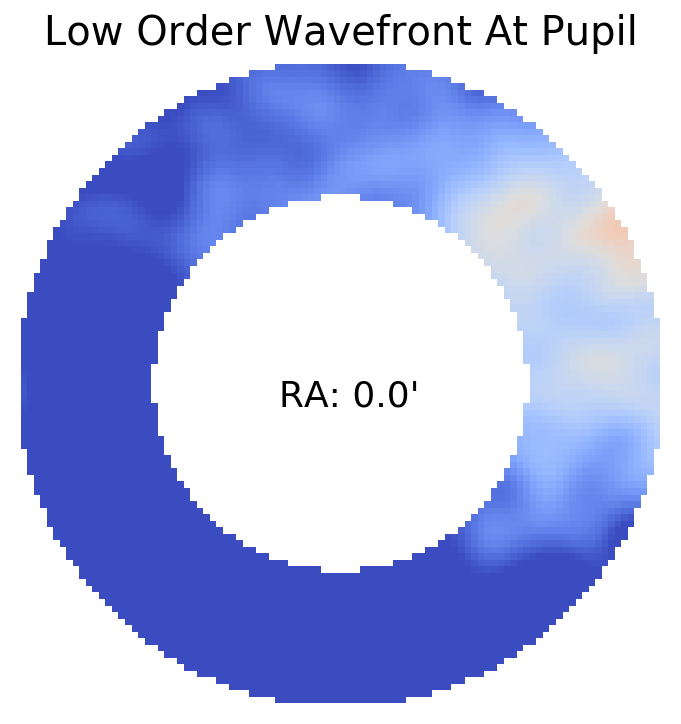

In [14]:
fps = 5
nSeconds = 15
time = 0
dec = 0

fig = plt.figure(figsize=(6, 6))
V = masked_array(atm.wavefront(X, Y, 0, (0*galsim.arcsec, 0*galsim.arcsec)), mask=mask)
plt.title('Low Order Wavefront At Pupil', fontsize=20)
im = plt.imshow(V*mask, origin='lower', cmap='coolwarm',vmin=-3000,vmax=3000)
# plt.colorbar()
txt = plt.text(40, 46, 'foo', color='k', fontsize=18)
plt.axis('off')

def animate(frame):
    ra = frame * 10
    V = masked_array(atm.wavefront(X, Y, time, (ra*galsim.arcsec, dec*galsim.arcsec)), mask=mask)
    txt.set_text(f"RA: {ra/60:.1f}'")
    im.set_array(V)
    return [txt,im]


ani = FuncAnimation(fig, animate, frames=fps*nSeconds,
                              interval=1000/fps, blit=True)

In [15]:
HTML(ani.to_html5_video())

In [120]:
ani.save('low_order_wavefront_at_pupil_ra.mp4')

# Second Kick

In [16]:
psf = atm.makePSF(500, diam=8.36)
_ = psf.drawImage(nx=1, ny=1, n_photons=1, rng=rng, method='phot')

In [17]:
def plotSecondKick(ax, psf):
    nphoton=1000
    pa = galsim.PhotonArray(nphoton)
    psf.second_kick._shoot(pa, rng)
    ax.scatter(pa.x, pa.y, s=4, color='#0074D9')
    
    cov = np.cov([pa.x, pa.y])
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    mean_x = np.mean(pa.x)
    mean_y = np.mean(pa.y)
    
    for n_std, col in [(2.355,'#FF4136')]:
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=col, alpha=0.7)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        scale_y = np.sqrt(cov[1, 1]) * n_std

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)

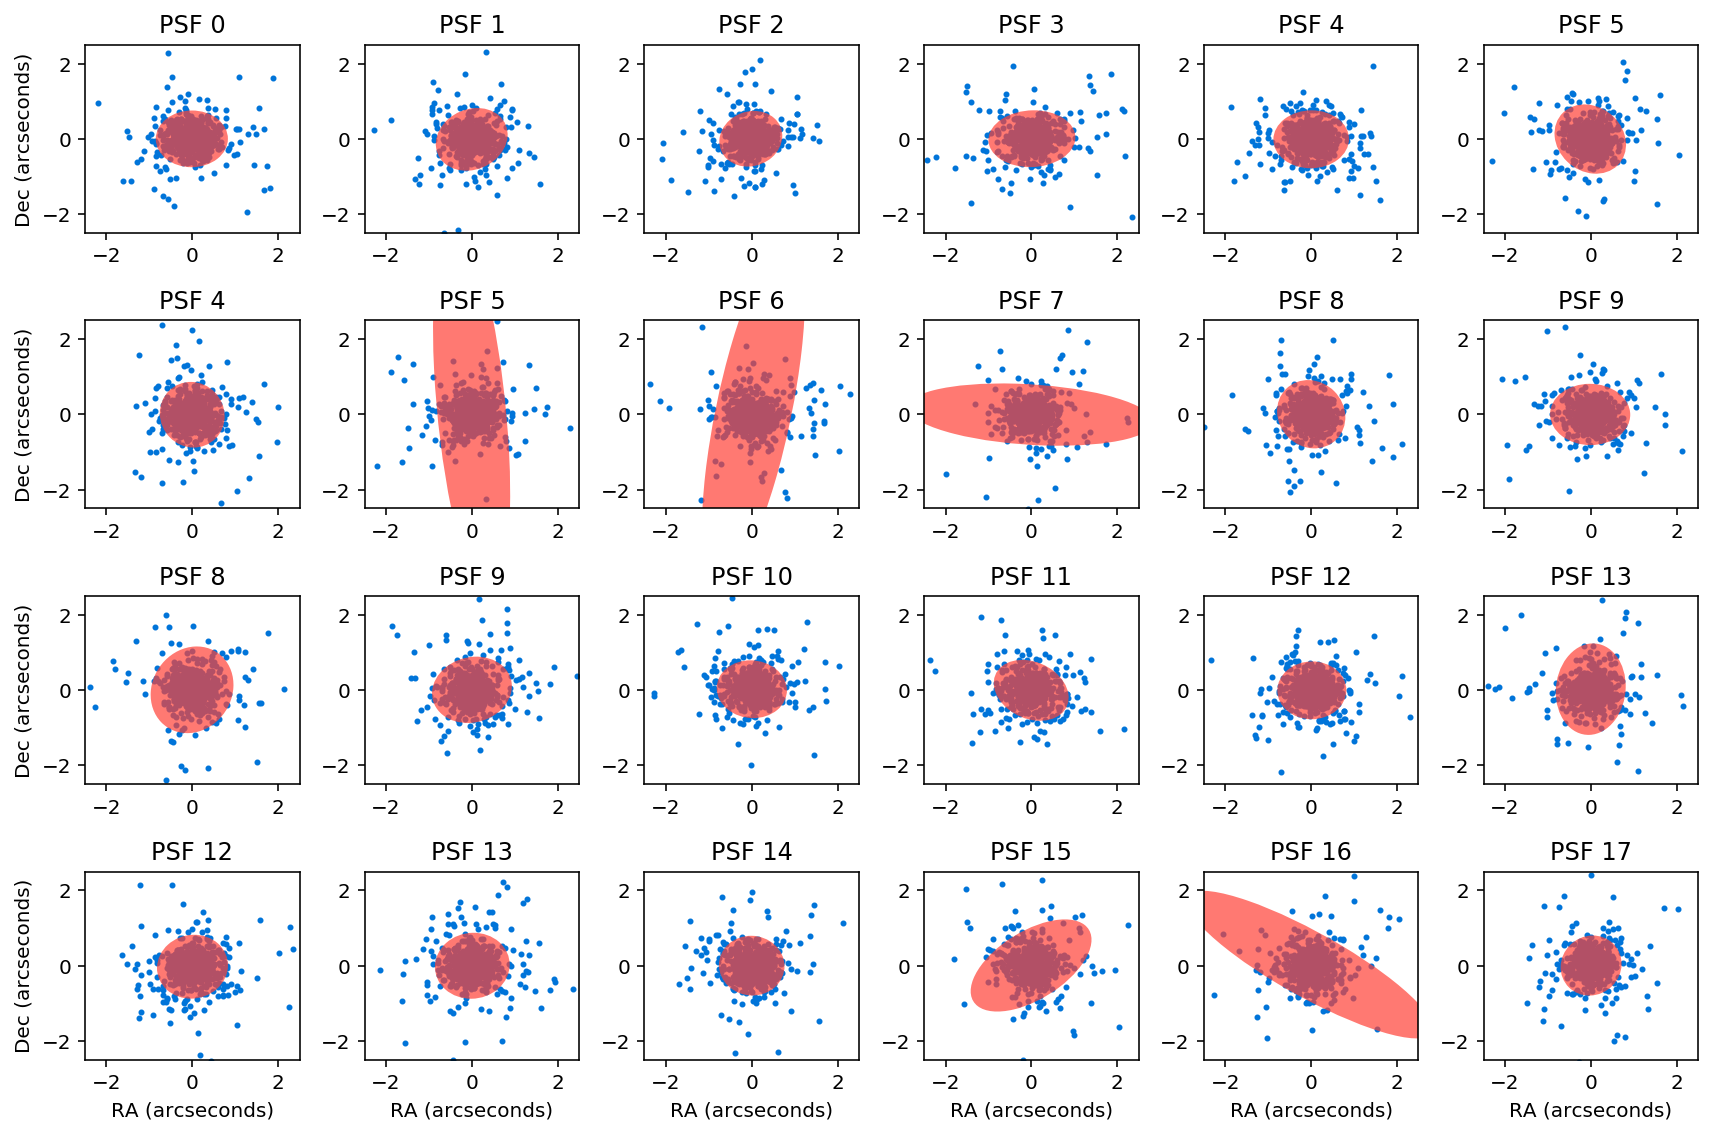

In [18]:
rng.reset()
rng.seed(2)
rows = 4
cols = 6
fig, axes = plt.subplots(rows,cols, figsize=(12,8))
for i in range(rows):
    for j in range(cols):
        ax = axes[i][j]
        plotSecondKick(ax, psf)
        ax.set_xlim([-2.5,2.5])
        ax.set_ylim([-2.5,2.5])
        if i == rows - 1:
            ax.set_xlabel('RA (arcseconds)')
        if j == 0:
            ax.set_ylabel('Dec (arcseconds)')
        ax.set_title(f'PSF {i*4 + j}')
fig.tight_layout()
fig.savefig('second_kick_psfs.png', dpi=80, bbox='tight')

# Brighter Fatter

In [120]:
nphoton = 1000000
pa = galsim.PhotonArray(nphoton)
sig = 3 / 2.35
x,y = np.random.multivariate_normal((0,0), np.array([[1,0],[0,1]])* sig ** 2, size=nphoton).T
pa.x = x
pa.y = y
pa.dxdz = 0
pa.dydz = 0
pa.wavelength = 500e-9
pa.flux = 1

# no BF
xedges = np.linspace(-5.5,4.5, 11)
yedges = xedges
result, _, _ = np.histogram2d(pa.x, pa.y, bins=[yedges, xedges])

# BF
sensor = galsim.SiliconSensor(strength=1)
image = galsim.Image(10, 10)  # hard code for now
image.setCenter(
    int(np.mean(x)),
    int(np.mean(y))
)
sensor.accumulate(pa, image)

1000000.0

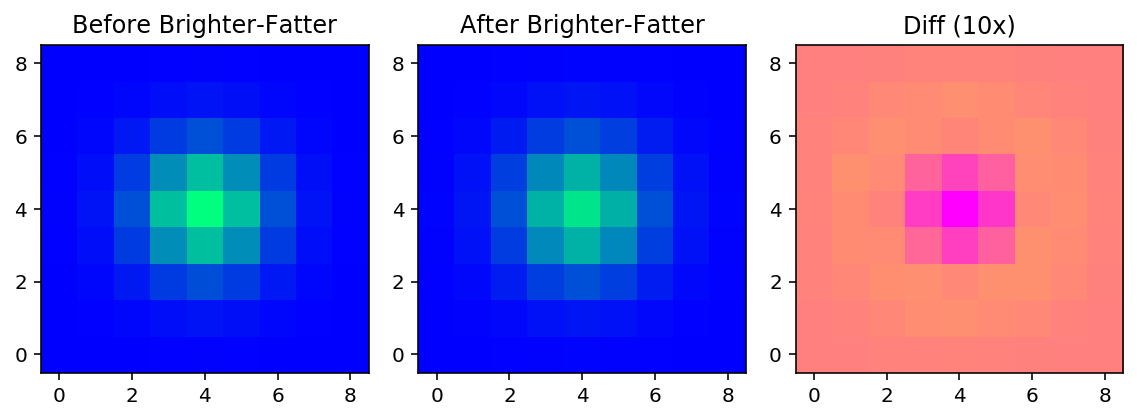

In [123]:
# plot
cmap = 'winter'
vmax = result.max()
vmin = 0

fig, axes = plt.subplots(1,3)
fig.set_size_inches(8,3)
axes[0].set_title('Before Brighter-Fatter')
axes[0].imshow(result[1:,1:], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)

axes[1].set_title('After Brighter-Fatter')
axes[1].imshow(image.array[1:,1:], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)

axes[2].set_title('Diff (10x)')
axes[2].imshow(image.array[1:,1:] - result[1:,1:], origin='lower', cmap='spring', vmin=-vmax / 10, vmax=vmax / 10)

fig.tight_layout()
fig.savefig('brighter_fatter.png', dpi=80, bbox='tight')

# SED and Differential Chromatic Refraction

In [ ]:

base_refraction = galsim.dcr.get_refraction(
    self.wavelength,
    self.observation['zenith'],
    temperature=self.observation['temperature'],
    pressure=self.observation['pressure'],
    H2O_pressure=self.observation['H2O_pressure'],
)
refraction = galsim.dcr.get_refraction(
    wavelengths,
    self.observation['zenith'],
    temperature=self.observation['temperature'],
    pressure=self.observation['pressure'],
    H2O_pressure=self.observation['H2O_pressure'],
)

# Refraction at Surface